# Modeling
## Estancia de investigación Maestría de Ciencia de Datos
## Aide Jazmín González Cruz

### 1. Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from siuba import *
import time
from time import gmtime, strftime

import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils


### 2. Carga de features y división de datos de entrenamiento y validación

In [2]:
df = utils.load_df("../Data/feature_sel2.pkl")
df.head(5)

,max_preglucosa,avg_preglucosa,min_preglucosa,avg_sistolica_a,edad_range,avg_diastolica_a,dm_años_int,dm_años_flt,ANTIARRITMICOS,num_med_preglucosa,...,OFTALMICOS,OTROS INOTROPICOS POSITIVOS,sintomas_signos_hallazgos_anormales_clin_lab_no_clasif,ANTIPALUDICOS,min_acido_urico,ANTISEPTICOS,ANTIPROSTATICOS,ANTIOSTEOPOROSICOS,enf_ot_partes_aparato_digestivo,label
0,373.000000,150.000000,108.000,119.523810,5.0,78.571429,1.184464,1.569907,0.0,9.0,...,0.0,0.0,1.0,0.0,4.96,0.0,0.0,0.0,0.0,0
1,253.000000,169.000000,109.000,120.000000,5.0,79.523810,1.184464,1.569907,0.0,3.0,...,0.0,0.0,1.0,0.0,4.96,0.0,0.0,0.0,0.0,0
2,253.000000,253.000000,253.000,120.476190,6.0,79.523810,1.184464,1.569907,0.0,1.0,...,0.0,0.0,1.0,0.0,4.96,0.0,0.0,0.0,0.0,0
3,210.000000,155.750000,80.000,122.842105,6.0,79.842105,1.184464,1.569907,0.0,4.0,...,0.0,0.0,1.0,0.0,4.96,0.0,0.0,0.0,0.0,1
4,198.358333,152.899811,119.675,100.000000,4.0,77.500000,1.184464,1.569907,0.0,5.0,...,0.0,0.0,1.0,0.0,4.96,0.0,0.0,0.0,0.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Columns: 148 entries, max_preglucosa to label
dtypes: float64(147), int64(1)
memory usage: 192.1 KB


In [4]:
X = df.loc[:, df.columns != 'label']
print(X.shape)
Y = df[["label"]]
print(Y.shape)

(166, 147)
(166, 1)


In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

In [6]:
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)
#X_train = X_res
#y_train = y_res

### 3. Magic Loop

- Diccionario de algoritmos a aplicar

In [7]:
algorithms_dict = {'tree': 'tree_grid_search',
                   'random_forest': 'rf_grid_search',
                   'logistic': 'logistic_grid_search',
                   'xgboost': 'xgboost_grid_search'}

- Diccionario de configuraciones

In [8]:
grid_search_dict = {
                        'tree_grid_search': {
                            'max_depth': [5, 10, 15],
                            'min_samples_leaf': [3, 5, 7]
                        },
                        'rf_grid_search': {
                            'n_estimators': [30, 50, 100],
                            'max_depth': [5, 10, 15],
                            'min_samples_leaf': [3, 5, 10]
                        },
                        'logistic_grid_search':{
                            'C':np.logspace(-3,3,7),
                            'penalty':['l2']
                        },
                        'xgboost_grid_search':{
                            'max_depth': range (2, 10, 1),
                            'n_estimators': range(60, 220, 40),
                            'learning_rate': [0.1, 0.01, 0.05]
                        }
                    }

- Diccionario de estimadores

In [9]:
from xgboost import XGBClassifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                   'random_forest': RandomForestClassifier(oob_score=True, random_state=2222),
                   'logistic': LogisticRegression(random_state=3333),
                   'xgboost': XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42)
                  } 

In [11]:
def magic_loop(algorithms, features, labels):
    best_estimators = []
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        #tscv = TimeSeriesSplit(n_splits=5)
        
        #gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=5, n_jobs=-1)
        gs = GridSearchCV(estimator, grid_params, scoring='roc_auc', cv=5, n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [12]:
#scoring_met= 'recall'
algorithms = ['tree', 'random_forest','logistic','xgboost']
models = []
start_time = time.time()
models_list = []

In [13]:
# Select dataframe columns with any NaN value
subset_df = X_train.loc[:, X_train.isnull().any()]
print(subset_df)

Empty DataFrame
Columns: []
Index: [28, 151, 39, 150, 94, 96, 111, 143, 162, 124, 147, 7, 83, 87, 22, 57, 43, 77, 90, 61, 129, 119, 108, 45, 63, 91, 157, 106, 70, 79, 12, 144, 110, 73, 71, 42, 122, 33, 44, 53, 149, 64, 164, 88, 134, 14, 19, 47, 3, 81, 20, 115, 51, 66, 93, 74, 49, 138, 100, 139, 35, 18, 163, 121, 38, 95, 142, 148, 135, 78, 118, 4, 48, 68, 30, 24, 46, 34, 75, 123, 109, 86, 6, 80, 27, 103, 11, 137, 98, 16, 161, 1, 13, 0, 52, 59, 116, 165, 140, 155, ...]

[116 rows x 0 columns]


In [14]:
X_train.columns.values.tolist()

['max_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'avg_sistolica_a',
 'edad_range',
 'avg_diastolica_a',
 'dm_años_int',
 'dm_años_flt',
 'ANTIARRITMICOS',
 'num_med_preglucosa',
 'num_med_presion_a',
 'ANTIANEMICOS',
 'avg_num_consultas_by_year',
 'sum_num_consultas',
 'max_colesterol',
 'avg_num_med',
 'max_num_med',
 'num_med',
 'ANTIMIGRANOSOS',
 'ANTIDEPRESIVOS',
 'ventana',
 'año_dx_dm',
 'epoca_nac',
 'avg_trigliceridos',
 'ANESTESICOS LOCALES',
 'avg_colesterol',
 'ANTIHIPERTENSIVOS',
 'max_diastolica_a',
 'max_trigliceridos',
 'min_sistolica_a',
 'enf_endocrinas',
 'ANTIDIABETICOS',
 'g14',
 'g5',
 'trigliceridos',
 'max_sistolica_a',
 'ANTIMICROBIANOS',
 'SEDANTES HIPNOTICOS',
 'imc_range',
 'CORTICOSTEROIDES',
 'DIURETICOS',
 'ANTIRREUMATICOS',
 'enf_sist_osteomuscular_y_tejido',
 'ANTIADRENERGICOS',
 'E65_E68',
 'dm',
 'E70_E90',
 'ANTITUSIGENOS',
 'num_med_colesterol',
 'min_trigliceridos',
 'num_med_trigliceridos',
 'ANTIGOTOSOS',
 'g6',
 'min_diastolica_a',
 'ANT

In [15]:
best = magic_loop(algorithms, X_train, y_train)
print("Selección de variables completada satisfactoriamente en ", time.time() - start_time, ' segundos')

Selección de variables completada satisfactoriamente en  3770.8860585689545  segundos


In [16]:
model0 = best[0].best_estimator_
model0

model1 = best[1].best_estimator_
model1

model2 = best[2].best_estimator_
model2

model3 = best[3].best_estimator_
model3

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=4,
              nthread=4, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...)

In [17]:
utils.save_df(model0, "../output/best_model0_av.pkl")
utils.save_df(model1, "../output/best_model1_av.pkl")
utils.save_df(model2, "../output/best_model2_av.pkl")
utils.save_df(model3, "../output/best_model3_av.pkl")

### 4. Evaluando modelo

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

In [19]:
predicted_labels0 = model0.predict(X_test)
predicted_scores0 = model0.predict_proba(X_test)

predicted_labels1 = model1.predict(X_test)
predicted_scores1 = model1.predict_proba(X_test)

predicted_labels2 = model2.predict(X_test)
predicted_scores2 = model2.predict_proba(X_test)

predicted_labels3 = model3.predict(X_test)
predicted_scores3 = model3.predict_proba(X_test)


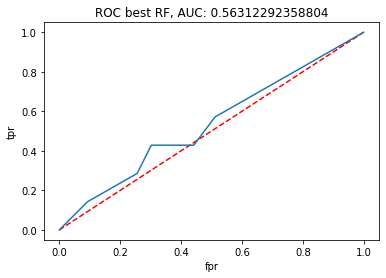

[[30 13]
 [ 4  3]]


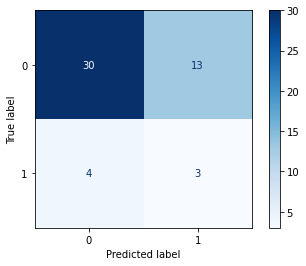

In [20]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores0[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels0)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

print(confusion_matrix(y_test, predicted_labels0))
plot_confusion_matrix(model0, X_test, y_test, cmap=plt.cm.Blues)  

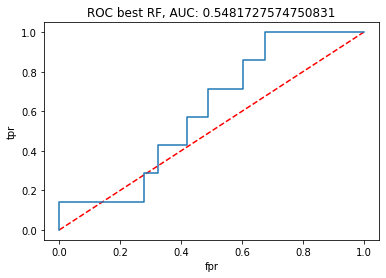

[[41  2]
 [ 6  1]]


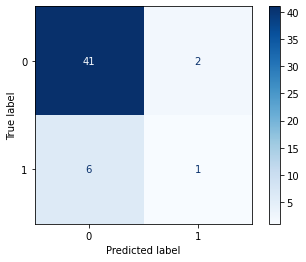

In [21]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores1[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels1)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

print(confusion_matrix(y_test, predicted_labels1))
plot_confusion_matrix(model1, X_test, y_test, cmap=plt.cm.Blues)  

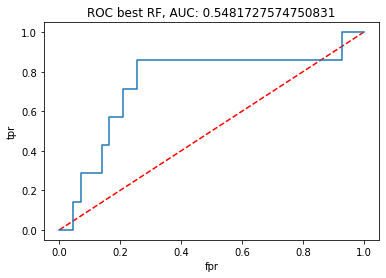

[[41  2]
 [ 6  1]]


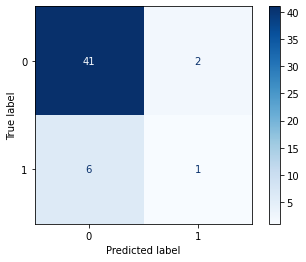

In [22]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores2[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels2)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

print(confusion_matrix(y_test, predicted_labels2))
plot_confusion_matrix(model2, X_test, y_test, cmap=plt.cm.Blues)  

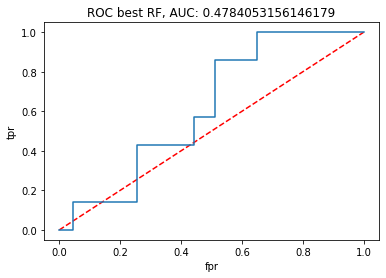

[[35  8]
 [ 6  1]]


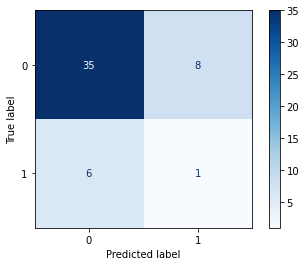

In [23]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores3[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels3)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

print(confusion_matrix(y_test, predicted_labels3))
plot_confusion_matrix(model3, X_test, y_test, cmap=plt.cm.Blues)  

In [24]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2, 'precision': precision,
                         'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)

    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']

    df = df_1.merge(df_2, on="threshold")

    return df

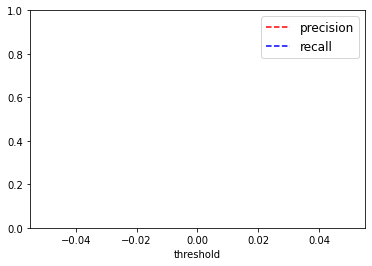

In [25]:
# Generando métricas
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores1[:, 1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
#save_metrics(metrics_report, '../output/metricas_offline.pkl')

# Curva: Precision-recall
plt.figure()
plt.plot(metrics_report['threshold'], metrics_report['precision'], 'k--', c="red", label='precision')
plt.plot(metrics_report['threshold'], metrics_report['recall'], 'k--', c="blue", label='recall')
plt.xlabel('threshold')
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('../output/recall_precision.png', bbox_inches='tight')
#plt.show()

In [26]:
# Curva: recall-precision @k
data_junta = pd.concat([X_test, y_test], axis=1)
data_filtrada = data_junta
datos_finales_X = pd.DataFrame(data_filtrada.drop(['label'], axis=1))
y_true = data_filtrada.label
y_scores = model1.predict_proba(datos_finales_X)

In [27]:
def param_graf(y_true, y_scores):
    k_values = np.linspace(0, 0.99, 100)
    lista = []

    for k in k_values:
        p_k = precision_at_k(y_true, pd.DataFrame(y_scores)[1], k)
        r_k = recall_at_k(y_true, pd.DataFrame(y_scores)[1], k)
        lista = lista + [[p_k, r_k, k]]

    p_r_g = pd.DataFrame(lista, columns=["p_k", "r_k", "k"])

    return p_r_g

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k * len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k * len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

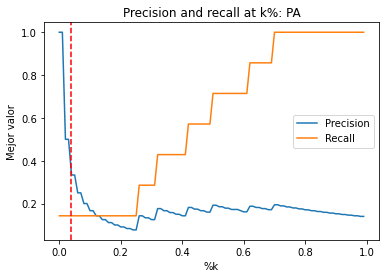

In [28]:
p_r_g = param_graf(y_true, y_scores)

plt.figure()
plt.plot(p_r_g["k"], p_r_g["p_k"], label="P")
plt.plot(p_r_g["k"], p_r_g["r_k"], label="R")
plt.title("Precision and recall at k%: PA")
plt.axvline(x=0.037, c='red', linestyle='--')
plt.ylabel("Mejor valor")
plt.legend(['Precision', 'Recall'])
plt.xlabel("%k")
plt.savefig('../output/recall_precision_k.png', bbox_inches='tight')
#plt.show()